<a href="https://colab.research.google.com/github/portoforigin/deeplearn/blob/main/fastai/PETS_SimilarCats_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Dependencies:**

 - Default version of fastai in Google Colab is 1.0.61(?), we need >v2.2.5

In [1]:
!pip install -Uqq fastai

import fastai
fastai.__version__

PROJECT_NAME = "FastAI_PETS"
MODEL_NAME = "fastai_pets_similarcats_001.pkl"

## **PETS Dataset**

Load the PETS dataset:

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

files = get_image_files(path/"images")
print("There are %s images" % (len(files)))


There are 7390 images


In [3]:
#create a directory for this challenge and build folders for each breed
dest = os.path.join(path, "challenge")
if not os.path.exists(dest):
  os.makedirs(dest)

ftypes = ("Ragdoll*", "Birman*")
import glob
for ftype in ftypes:
  for fname in glob.glob(r"%s/images/%s"%(path, ftype)):
    shutil.copy(fname, dest)
    

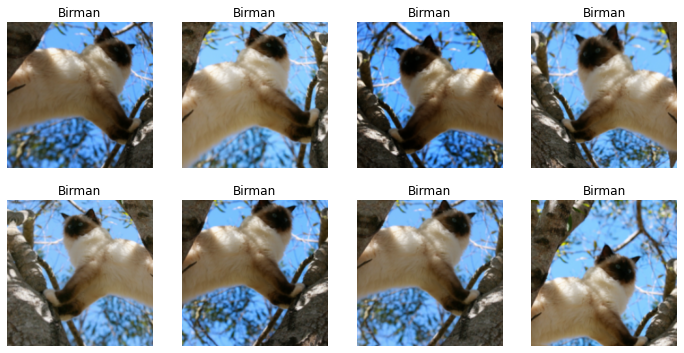

In [4]:
# Label is parsed from file name
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(224),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )
dls = pets.dataloaders(path/"challenge")
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## **Build a Simple Model**

In [5]:
# Train Model with RESNET34
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.091930,0.533955,0.187500,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.694016,0.481485,0.175000,00:03


**That's a terrble error rate: 17.5%!!!!**

Lets look at the confusion matrix and top losses:

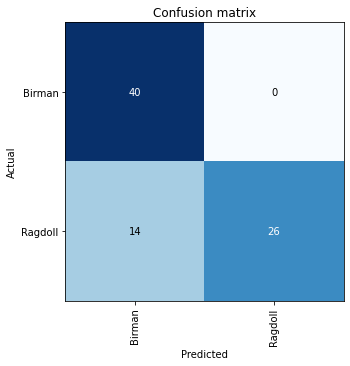

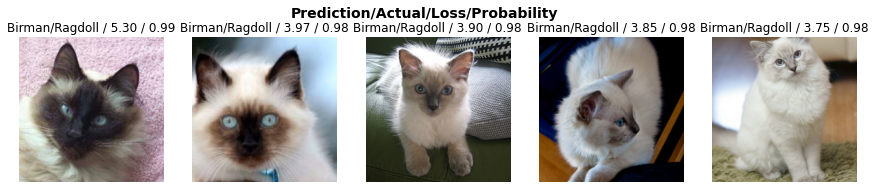

In [7]:
# Let's take a look at the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))
interp.most_confused(min_val=5)
interp.plot_top_losses(5, nrows=1)

## **Let's build a better Model**

Things to try:
- Add data augmentation to input images
- Try a different base model (RESNET101, AlexNet, etc)
- Tune the learning rate***
- Go Deeper***

*** These steps didn't improve things...but did help when training againts all 37 breeds in [FastAI_PETS_Learning_Rate.ipynb](https://colab.research.google.com/drive/1qtc2k894bBKcDfo9OAOYapjioCKC4Qb5#scrollTo=BTiPUt268c3V)

## **1) Data Augmentation**
- Apply batch transforms (scaling, etc)
(More things to try in [FastAI_PETS_Playground.ipynb](https://colab.research.google.com/drive/1Is0qBT2HqrE4t8rY2PZ9kZhUCzHBH9NF) that I haven't explored yet)

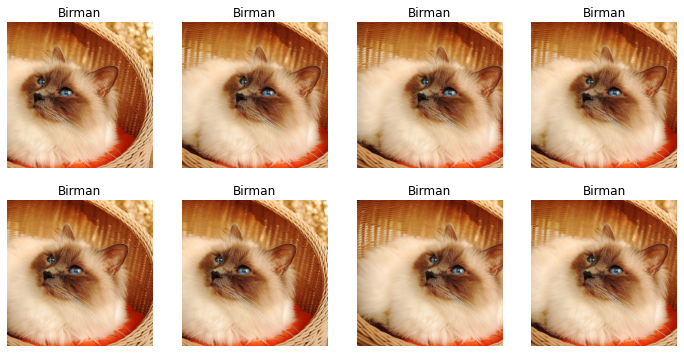

In [8]:
# Only Resize Operation Applied to data
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=1),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(224),
                 )
dls = pets.dataloaders(dest)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

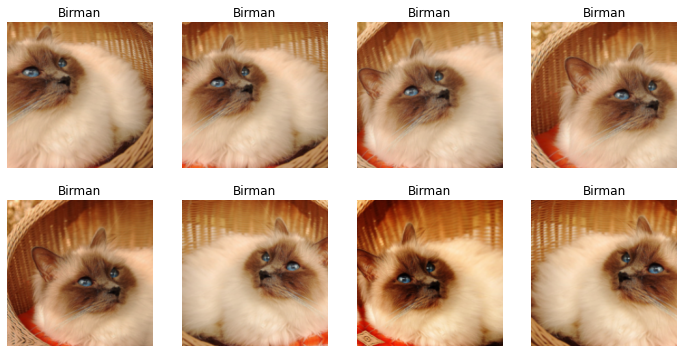

In [9]:
# Batch Transform
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=1),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(224),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75)
                 )
dls = pets.dataloaders(dest)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [10]:
# Let's build a model w/ new dataset
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.945315,0.431131,0.175000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.427110,0.341466,0.100000,00:03


**Error Rate droped to 12.5% from 17.5%!!!**

## **2) Let's try a new base model**
The bigger models require more layers to be beneficial, let's run 5 epochs

**Summary:** 
- RESENT looks like the best model, but there are so many knobs that can be tweaked
- RESNET101 gave best performance w/ 7.5% error rate

In [11]:
# RESNET34
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.948751,1.464443,0.475000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.494119,0.644494,0.187500,00:03
1,0.413880,0.453452,0.125000,00:03
2,0.331206,0.482424,0.125000,00:03
3,0.260665,0.487995,0.112500,00:03
4,0.228377,0.441419,0.112500,00:03


In [12]:
# RESNET101
learn = cnn_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.927721,0.396824,0.100000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.449704,0.705191,0.187500,00:09
1,0.307942,0.637098,0.125000,00:08
2,0.269982,0.706010,0.087500,00:08
3,0.245590,0.578205,0.087500,00:08
4,0.197878,0.476485,0.100000,00:08


In [13]:
# RESNET152
# - to_fp16() uses half precision floats...resnet152 with full floats ran out of CUDA memory...oops
learn = cnn_learner(dls, resnet152, metrics=error_rate).to_fp16()
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.070157,2.035307,0.450000,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.467196,1.178046,0.275000,00:06
1,0.398324,0.407163,0.062500,00:06
2,0.293284,0.575196,0.100000,00:06
3,0.232713,0.411822,0.112500,00:06
4,0.204390,0.357438,0.112500,00:06


**NOTE: TRAIN_LOSS continues to decrease, but VALID_LOSS is starting to increase which means over fitting**

In [14]:
# ALEXNET
learn = cnn_learner(dls, alexnet, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.135909,1.491510,0.387500,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.696798,0.652341,0.250000,00:02
1,0.686833,0.548257,0.162500,00:02
2,0.598680,0.519445,0.150000,00:02
3,0.541238,0.489187,0.137500,00:02
4,0.518838,0.475901,0.137500,00:02


In [15]:
# VGG19
learn = cnn_learner(dls, vgg19_bn, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.176618,0.632072,0.262500,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.599154,0.389700,0.162500,00:11
1,0.480928,0.307483,0.125000,00:09
2,0.434293,0.269461,0.112500,00:08
3,0.378543,0.237198,0.112500,00:08
4,0.332313,0.243849,0.125000,00:08


## **3) Tune Learning Rate**
For simplicity I'm going to focus on Resnet101, but would like to explore Resnet152 w/ deeper layers

Default learning rate is 2e-3 for fine_tune()

Minimum/10: 1.20e-02, steepest point: 1.10e-06


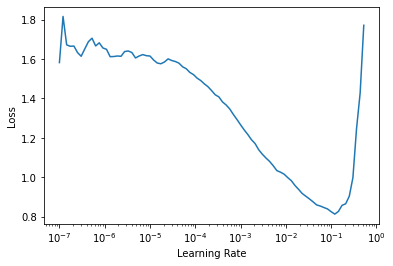

In [16]:
# Find an optimal learning rate
learn = cnn_learner(dls, resnet34, metrics=error_rate)

lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [17]:
# Let's try the Min point
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5, base_lr=1.7e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.827524,1.149578,0.125000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.035105,0.624071,0.087500,00:03
1,0.831670,2.115667,0.300000,00:03
2,0.621732,0.881538,0.212500,00:03
3,0.489525,0.646202,0.112500,00:03
4,0.398461,0.441957,0.087500,00:03


In [18]:
# Let's try the steepest point
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5, base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.244845,1.202694,0.475000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.837052,0.663934,0.275000,00:03
1,0.635823,0.406233,0.125000,00:03
2,0.555062,0.323480,0.100000,00:03
3,0.477104,0.276966,0.062500,00:03
4,0.436315,0.257316,0.062500,00:03


## **4) Go Deeper**
Let's expirement w/ deeper layers

Minimum/10: 1.20e-02, steepest point: 8.32e-04


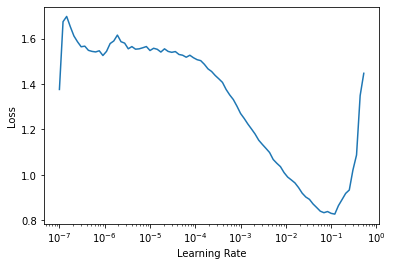

In [19]:
# Lets try steepest
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,error_rate,time
0,1.357096,1.517904,0.412500,00:03
1,0.834820,0.836788,0.150000,00:03
2,0.647871,0.667942,0.137500,00:03


Minimum/10: 2.09e-04, steepest point: 2.75e-06


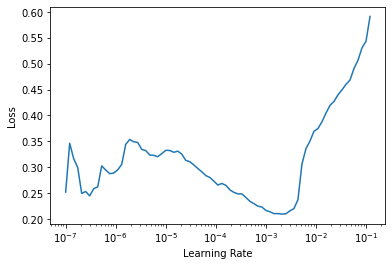

In [20]:
learn.fit_one_cycle(3, lr_max=2.0e-3)

learn.unfreeze()

lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [21]:
learn.fit_one_cycle(12, lr_max=slice(5e-5, 1.2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.346498,0.532538,0.137500,00:03
1,0.306154,0.517690,0.112500,00:03
2,0.274894,0.402963,0.087500,00:03
3,0.248134,0.468580,0.087500,00:03
4,0.211103,0.496784,0.087500,00:03
5,0.202556,0.337714,0.075000,00:03
6,0.175267,0.280254,0.075000,00:03
7,0.152756,0.250332,0.087500,00:03
8,0.136270,0.215901,0.075000,00:03
9,0.129314,0.218978,0.062500,00:03


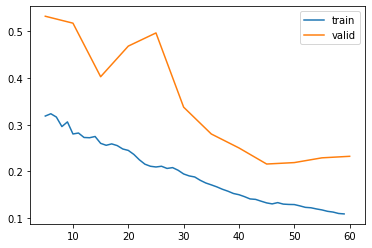

In [22]:
# Lets Plot Loss
learn.recorder.plot_loss()

## **What's Going On?**

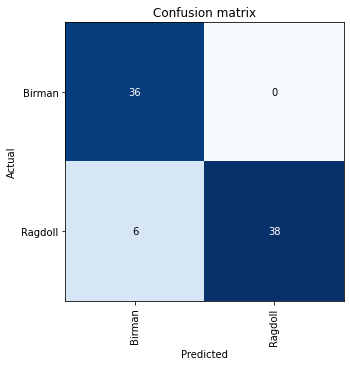

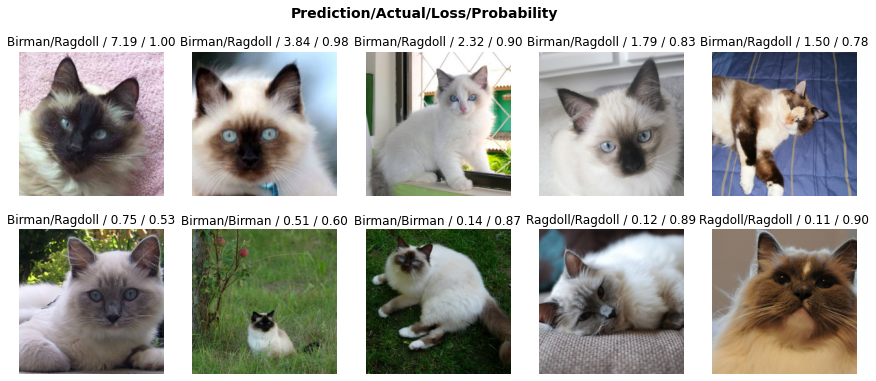

In [23]:
# Let's take a look at the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))
interp.most_confused(min_val=5)
interp.plot_top_losses(10, nrows=2)